In this notebook we will explore the application of matrix factorization techniques to a simple dataset.  We will use synthetic data where the underlying structure is known.

In [177]:
import pandas,numpy
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage,cophenet
from scipy.spatial.distance import pdist

from sklearn.decomposition import PCA,FactorAnalysis,NMF
from sklearn.model_selection import KFold,cross_val_score
from sklearn.preprocessing import scale
from sklearn.metrics import euclidean_distances
from sklearn.manifold import MDS,TSNE

import matplotlib.pyplot as plt
from IPython.display import Image

recreate=True
if recreate:
    seed=20698
else:
    seed=numpy.ceil(numpy.random.rand()*100000).astype('int')
    print(seed)
    
%matplotlib inline
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [94]:
noise_sd=1
grand_mean=100
varmean_sd=10
nobs=500
X=numpy.random.randn(nobs,3)
p=numpy.zeros((3,9))
p[0,:3]=0.5
p[1,3:6]=1.0
p[2,6:9]=1.5
# add nonzero means to the variables to make them more realistic
data=X.dot(p)+numpy.random.randn(nobs,9)*noise_sd
data=scale(data)
data=pandas.DataFrame(data,columns=['V%d'%i for i in range(1,10)])


Take a look at the data to make sure that they look reasonable.

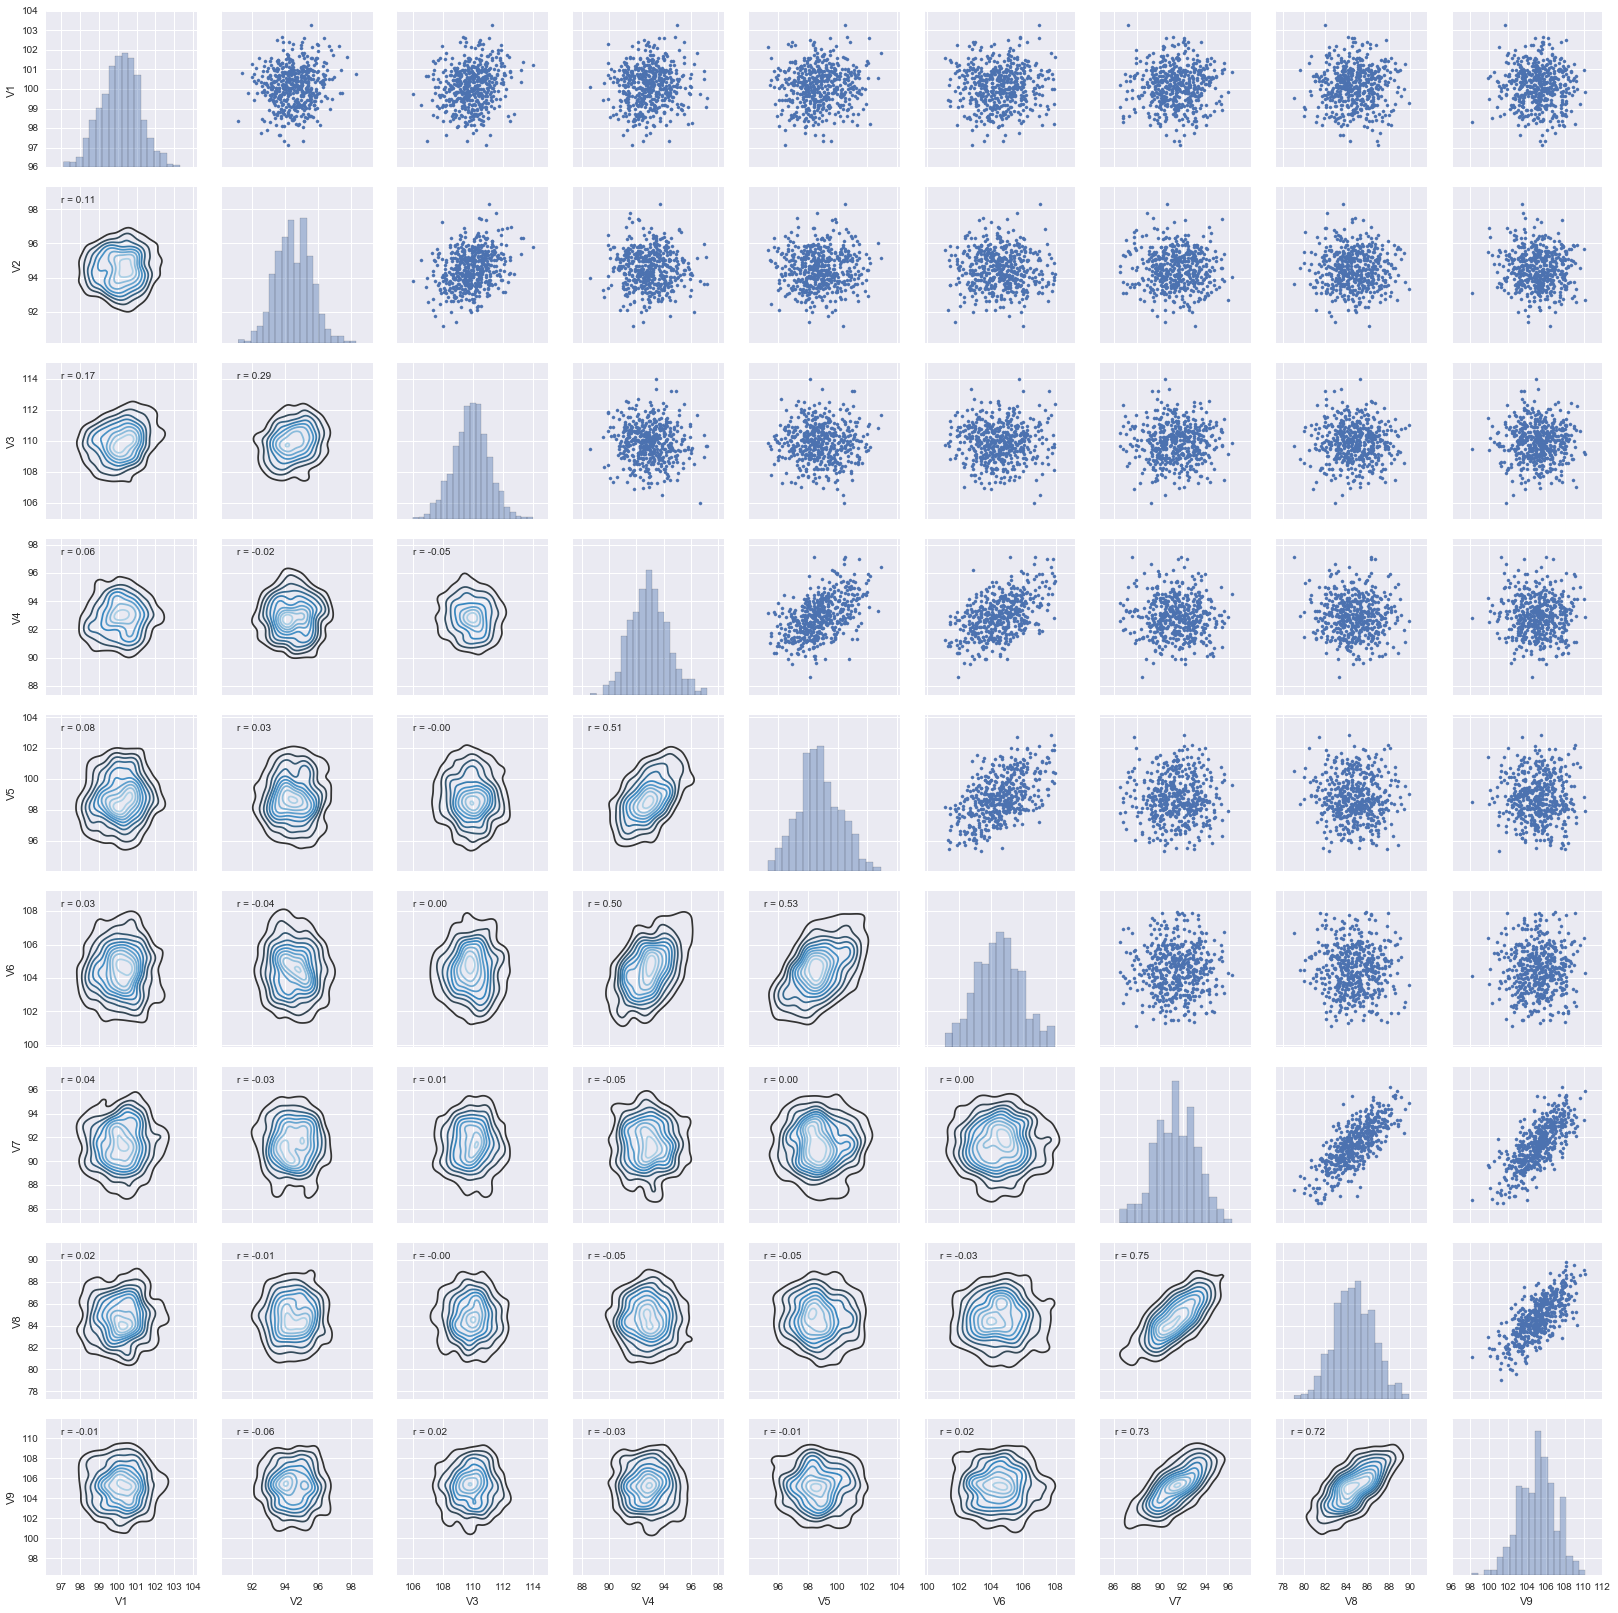

In [43]:
#sns.pairplot(data)
def corrfunc(x, y, **kws):
    r = numpy.corrcoef(x, y)[0,1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)

g = sns.PairGrid(data, palette=["red"])
g.map_upper(plt.scatter, s=10)
g.map_diag(sns.distplot, kde=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_lower(corrfunc)

#### Clustering

A simple way to understand the multivariate structure of a dataset is to use hierarchical clustering.  

Clustering is based on an estimate of the distances between variables.  It is critically important that the data are properly scaled before distances are computed on them. There are many different methods that one can use to compute the linkage; I generally find that Ward's method (which minimizes within-cluster variance) performs well in terms of giving reasonable clustering trees.  

__Exercise:__ Test it out by plugging in various other methods into the linkage function ('average','complete','single','median')

cophenetic correlation: 0.916315081802


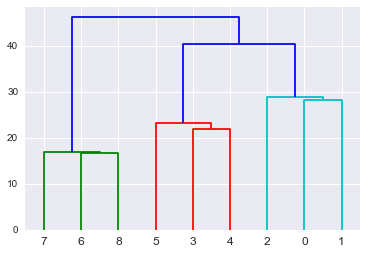

In [95]:
Z = linkage(data.T, 'ward')
c,cpd=cophenet(Z,pdist(data.T))
print('cophenetic correlation:',c)
dendro=dendrogram(Z)

#### Principal component analysis (PCA)

Principal component analysis finds a set of orthogonal (i.e. uncorrelated) factors that describe decreasing amounts of the variance in a dataset.

Let's perform principal components analysis on the simulated data, using the sklearn PCA() function.  We will plot the amount of variance accounted for by each component, as well as the loadings for the first three components.

(-1, 1)

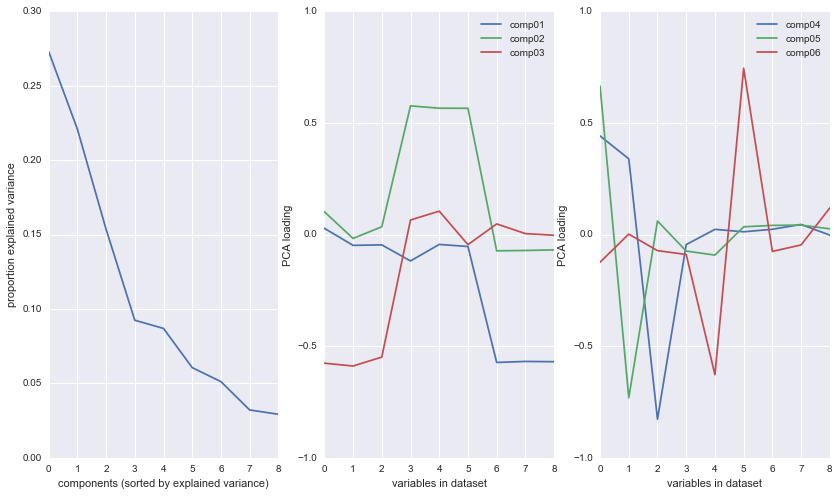

In [96]:
pca_full=PCA(whiten=True)
pca_full.fit(data)
fig=plt.figure(figsize=(14,8))
plt.subplot(131)
plt.plot(pca_full.explained_variance_ratio_)
plt.xlabel('components (sorted by explained variance)')
plt.ylabel('proportion explained variance')
plt.subplot(132)
plt.plot(pca_full.components_[:3,:].T)
plt.xlabel('variables in dataset')
plt.ylabel('PCA loading')
plt.legend(['comp%02d'%i for i in range(1,4)])
plt.ylim([-1,1])
plt.subplot(133)
plt.plot(pca_full.components_[3:6,:].T)
plt.xlabel('variables in dataset')
plt.ylabel('PCA loading')
plt.legend(['comp%02d'%i for i in range(4,7)])
plt.ylim([-1,1])

There are a number of ways to determine the "right" number of components.  One generic solution is to use crossvalidation.  We estimate the solution across a range of dimensionalities, and in each case we look at the log-likelihood of the held-out data and choose the # of components that maximizes this. This demo is based on code from http://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_fa_model_selection.html

In [97]:
pca=PCA( n_components = 'mle', svd_solver = 'full',whiten=True)
pca.fit(data)
print('best # of components by MLE:',pca.n_components_)
print('proportion variance explained:',numpy.sum(pca.explained_variance_ratio_))


best # of components by MLE: 7
proportion variance explained: 0.938658009343


In [98]:
kf=KFold(4)
pca = PCA(svd_solver='full',whiten=True)

pca_scores = []

for dims in range(1,data.shape[1]):
        pca.n_components = dims
        pca_scores.append(numpy.mean(cross_val_score(pca, data)))

pca_scores=numpy.array(pca_scores)

best # of components by cross-validation: 6


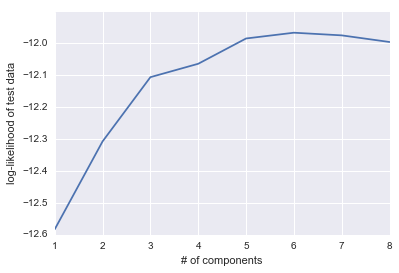

In [99]:
print('best # of components by cross-validation:',numpy.argmax(pca_scores)+1)
plt.plot(range(1,pca_scores.shape[0]+1),pca_scores)
plt.xlabel('# of components')
plt.ylabel('log-likelihood of test data')

We can also plot the components against one another in variable space to see how they relate across the variables.

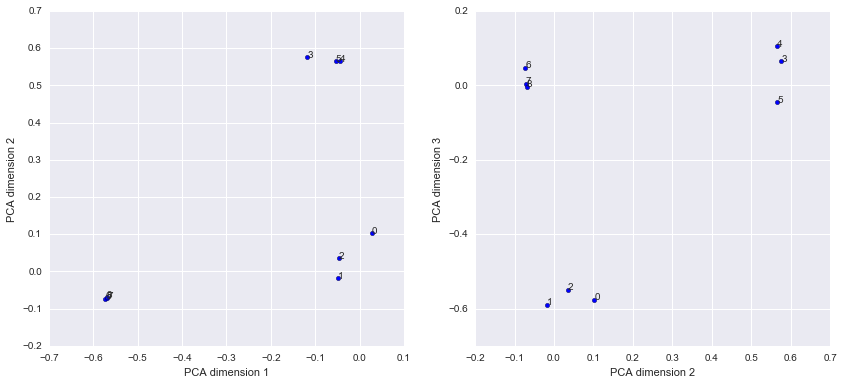

In [100]:
pca.fit(data)
#plt.scatter(pca.components_[0,:],pca.components_[1,:])
fig=plt.figure(figsize=(14,6))
for i in range(2):
    plt.subplot(1,2,i+1)
    ax=plt.gca()
    plt.scatter(pca.components_[i,:],pca.components_[i+1,:])
    plt.xlabel('PCA dimension %d'%int(i+1))
    plt.ylabel('PCA dimension %d'%int(i+2))

    for j in range(len(pca.components_[i,:])):
        ax.annotate('%d'%j, (pca.components_[i,j],pca.components_[i+1,j]))

### Factor analysis

Factor analysis is a *latent variable* model, defined as:

$$x-\mu =LF+\varepsilon .\ $$

where $x-\mu$ are the original data after removing the mean for each column, $F$ are a set of latent *factors*, $L$ are the loadings of each variable on each factor, and $\varepsilon$ are errors that are independent of F.  The additional assumptions of the model are $E(F)=0$ and $Cov(F)=I$ (i.e. the factors are uncorrelated with equal variance).

Let's compare the results of FA and PCA on the same dataset.

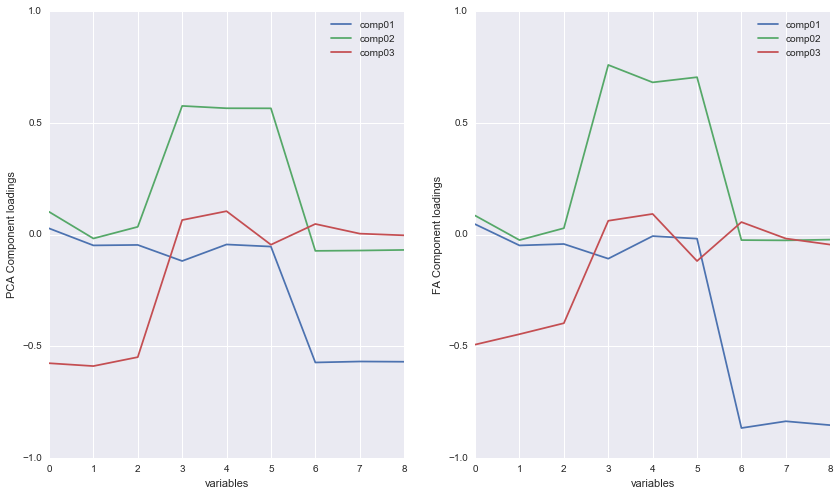

In [110]:
ncomps=8
fa=FactorAnalysis(ncomps)
pca=PCA(ncomps,svd_solver='full',whiten=True)
fa.fit(data)
plt.figure(figsize=(14,8))
pca.fit(data)
plt.subplot(1,2,1)
plt.plot(pca.components_[:3,:].T)
plt.ylim([-1,1])
plt.xlabel('variables')
plt.ylabel('PCA Component loadings')
plt.legend(['comp%02d'%i for i in range(1,4)])
plt.subplot(1,2,2)
plt.plot(fa.components_[:3,:].T)
plt.ylim([-1,1])
plt.xlabel('variables')
plt.ylabel('FA Component loadings')
plt.legend(['comp%02d'%i for i in range(1,4)])



Just as we used crossvalidation to determine the optimal dimensionality of PCA, we can do the same for FA, as long as we have a scoring function that can give us the likelihood of a set of data under some particular model (which is provided by sklearn).

In [111]:
kf=KFold(4)
fa = FactorAnalysis()

fa_scores = []

for dims in range(1,data.shape[1]):
        fa.n_components = dims
        fa_scores.append(numpy.mean(cross_val_score(fa, data)))

fa_scores=numpy.array(fa_scores)


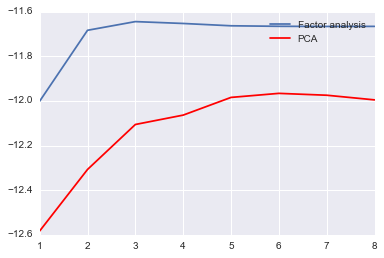

In [112]:
plt.plot(range(1,data.shape[1]),fa_scores)
plt.plot(range(1,data.shape[1]),pca_scores,'r')
plt.legend(['Factor analysis','PCA'])

In [113]:
print('best # of components by cross-validation:',numpy.argmax(fa_scores)+1)

best # of components by cross-validation: 3


#### Independent component analysis (ICA)

ICA is another way to decompose a matrix into components. Instead of finding components that are orthogonal (as PCA does) it instead finds components that are independent.  Independent components are orthogonal, but orthogonal components are not necessarily independent (e.g. if there are non-Gaussian signals in the data, then they will not be).  ICA takes  advantage of the fact that mixtures of signals are usually Gaussian but interesting sources generally are not.

The probabilistic ICA model is:

$$  x=As+n$$

with mixing matrix $A$ and the sources $s$ and  $ n\sim N(0,\operatorname{diag}(\Sigma))$

Let's make two different underlying components and combine them.  There is an infinite number of possible mixing matrices/sources that could satisfy this problem.  

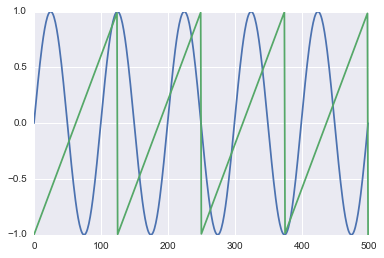

In [105]:
import scipy.signal
t = numpy.linspace(0, 10*numpy.pi, 500)
f1=numpy.sin(t)
plt.plot(f1)
t = numpy.linspace(0, 8*numpy.pi, 500)
f2=scipy.signal.sawtooth(t)
plt.plot(f2)
X=numpy.vstack((f1,f2)).T
d=X.dot(numpy.random.randn(2,10))+numpy.random.randn(X.shape[0],10)*0.1

In [106]:
from sklearn.decomposition import FastICA
ica=FastICA(2)
S=ica.fit_transform(d)

[[  1.00000000e+00   2.49800181e-16]
 [  2.49800181e-16   1.00000000e+00]]
[[  1.00000000e+00   8.52651283e-17]
 [  8.52651283e-17   1.00000000e+00]]


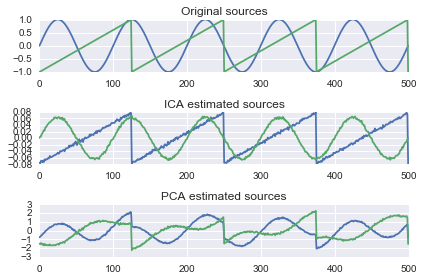

In [107]:
plt.subplot(3,1,1)
plt.plot(X)
plt.title('Original sources')
plt.subplot(3,1,2)
plt.plot(S)
plt.title('ICA estimated sources')
print(numpy.corrcoef(S.T))
plt.subplot(3,1,3)
pca=PCA(2,whiten=True)
p=pca.fit_transform(d)
plt.plot(p)
print(numpy.corrcoef(p.T))
plt.title('PCA estimated sources')
plt.tight_layout()

(array([ 24.,  43.,  50.,  79.,  61.,  64.,  67.,  50.,  43.,  19.]),
 array([-2.07231973, -1.65281179, -1.23330384, -0.8137959 , -0.39428796,
         0.02521998,  0.44472792,  0.86423586,  1.2837438 ,  1.70325174,
         2.12275968]),
 <a list of 10 Patch objects>)

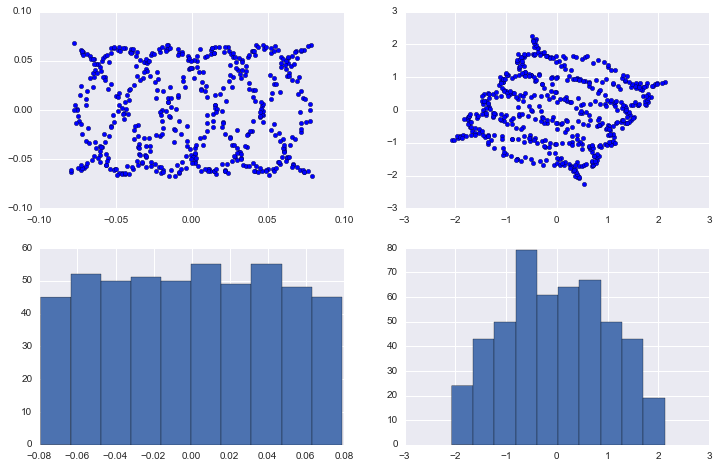

In [108]:
plt.figure(figsize=(12,12))
plt.subplot(3,2,1)
plt.scatter(S[:,0],S[:,1])
plt.subplot(3,2,2)
plt.scatter(p[:,0],p[:,1])
plt.subplot(3,2,3)
plt.hist(S[:,0])
plt.subplot(3,2,4)
plt.hist(p[:,0])

Let's apply ICA to our simulated data from above and see what it finds.  We can plot the mixing matrix, which shows how each component 

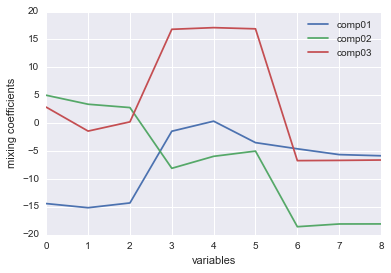

In [114]:
ica=FastICA(3)
S=ica.fit_transform(data)
plt.plot(ica.mixing_)
plt.xlabel('variables')
plt.ylabel('mixing coefficients')
plt.legend(['comp%02d'%i for i in range(1,4)])


#### Multidimensional scaling

Sometimes we want to understand the similarity of different observations in a multidimensional space.  One way to do this is to project the distances into a lower-dimensional space that preserves as much of the original distance between observations as possible.  One common way to do this is multidimensional scaling.  

Let's first generate some data from 100 voxels for stimuli from three different classes of objects (faces, houses, and cars), under the assumption that each object class is associated with a particular pattern of activity across those voxels.  We let the intensity of the pattern vary between stimuli within each class, such that there are better and worse examples of each category; you can think of these as perturbations of a prototype.  Let's also make the third category be more variable than the other two.



In [277]:
nvox=100
ncats=3
nstim=20 # per category
noise_sd=3
loadvar=[2,2,4]
X=numpy.random.randn(nvox,ncats) # pattern for each category
# category indicator for each stimulus 
stimidx=numpy.zeros((ncats,nstim*ncats))
for i in range(ncats):
    stimidx[i,(i*nstim):((i+1)*nstim)]=numpy.random.rand(nstim)*loadvar[i]+1
patterns=X.dot(stimidx)+ numpy.random.randn(nvox,ncats*nstim)*noise_sd
patterns=patterns.T  # reorient so that observations are on rows

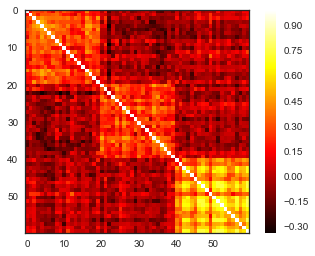

In [278]:
with sns.axes_style("white"):
    plt.imshow(numpy.corrcoef(patterns),cmap='hot',interpolation='nearest')
plt.colorbar()

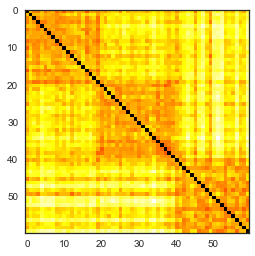

In [279]:
d=euclidean_distances(scale(patterns))
with sns.axes_style("white"):
    plt.imshow(d,cmap='hot',interpolation='nearest')


In [280]:
mds = MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed,
                   dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(d).embedding_

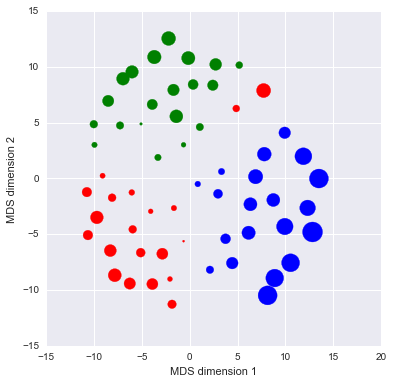

In [281]:
stimsize=numpy.sum(stimidx,0)-1
cols=['g','r','b']
plt.figure(figsize=(6,6))
for i in range(ncats):
    plt.scatter(pos[stimidx[i,:]>0,0],pos[stimidx[i,:]>0,1],color=cols[i],s=100*stimsize[stimidx[i,:]>0])
plt.xlabel('MDS dimension 1')
plt.ylabel('MDS dimension 2')

Let's see how this compares to the projection from PCA

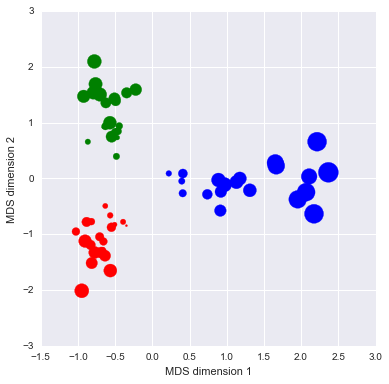

In [282]:
pca=PCA(2, whiten=True)
p_pca=pca.fit_transform(scale(patterns))
cols=['g','r','b']
plt.figure(figsize=(6,6))
for i in range(ncats):
    plt.scatter(p_pca[stimidx[i,:]>0,0],p_pca[stimidx[i,:]>0,1],color=cols[i],s=100*stimsize[stimidx[i,:]>0])

plt.xlabel('MDS dimension 1')
plt.ylabel('MDS dimension 2')

#### Representational similarity analysis


Representational similarity analysis (RSA) is an analysis that examines the similarity of neural response patterns across different stimuli; the foregoing MDS analysis could be considered one example of an RSA.  Often, however, we want to perform analyses across the individual stimuli, rather than simply placing them into a low-dimensional space.

Let's start by computing the distances between each stimulus (which we refer to as a representational dissimilarity matrix, or RDM); above we computed distances using Euclidean distance, but here we use the more common 1 - correlation metric.




In [309]:
corrdist=1-numpy.corrcoef(patterns)
# we don't want to include self-similarity, so let's set those to NA
corrdist[numpy.diag_indices_from(corrdist)]=numpy.nan
catnames=['face','house','car']

simresults=[]
for i in range(corrdist.shape[0]):
    for j in range(corrdist.shape[0]):
        if i==j:
            continue
        simresults.append([i,j,catnames[numpy.where(stimidx[:,i]>0)[0]],catnames[numpy.where(stimidx[:,j]>0)[0]],corrdist[i,j]])
simresults=pandas.DataFrame(simresults,columns=['i','j','Category_i','Category_j','Dissimilarity'])

/Users/poldrack/anaconda/envs/py34/lib/python3.4/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


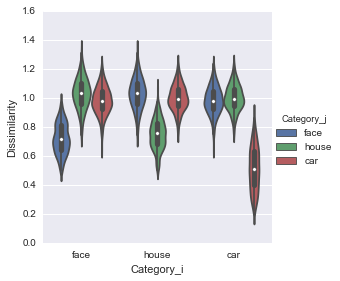

In [305]:
g = sns.factorplot(x="Category_i", y="Dissimilarity", hue="Category_j", data=simresults, kind="violin")
